## C-RAG stands for Corrective Retrieval-Augmented Generation.

It's an advanced version of the standard RAG you're already familiar with. The main goal of C-RAG is to fix a major weakness in standard RAG: what happens when the retriever fetches irrelevant or low-quality documents?

A standard RAG system will blindly pass those bad documents to the LLM, leading to hallucinations or incorrect answers. C-RAG adds a "self-correction" or "self-reflection" layer to prevent this.


## How C-RAG Works
C-RAG introduces a crucial new component called a Retrieval Evaluator. This evaluator acts like a quality-control gate after retrieval but before generation.

## The workflow looks like this:

1. **Retrieve:** Same as standard RAG, the system retrieves a set of documents from the vector database based on the user's query.

2. **Evaluate (The "C" part):** This is the new step. The Retrieval Evaluator (often a smaller, fine-tuned model) assesses the relevance of each retrieved document against the original query. It assigns a confidence score (e.g., 'correct', 'incorrect', or 'ambiguous').

3. **Act (The "Corrective" part):** Based on the evaluator's scores, C-RAG uses conditional logic to decide what to do next. This is where its power lies:

- **If 'Correct':** The documents are high-quality and relevant. The system proceeds just like standard RAG and passes them to the LLM for answer generation. Some C-RAG systems even perform an extra "knowledge refinement" step here, breaking the document into smaller "knowledge strips" and filtering out any irrelevant sentences to make the context even cleaner.

- **If 'Incorrect':**  All retrieved documents are irrelevant or "noisy." Instead of passing this bad context to the LLM (which would cause hallucinations), C-RAG discards them. It then triggers a new action, typically a web search, to find new, up-to-date information from the internet. This new information is then used to generate the answer.

- **If 'Ambiguous':** The results are mixed. The system might use a hybrid approach, combining the "correct" pieces of the retrieved documents with a supplementary web search to get the best of both worlds.

4. **Generate:** Finally, the LLM generates the answer using the corrected and verified context.

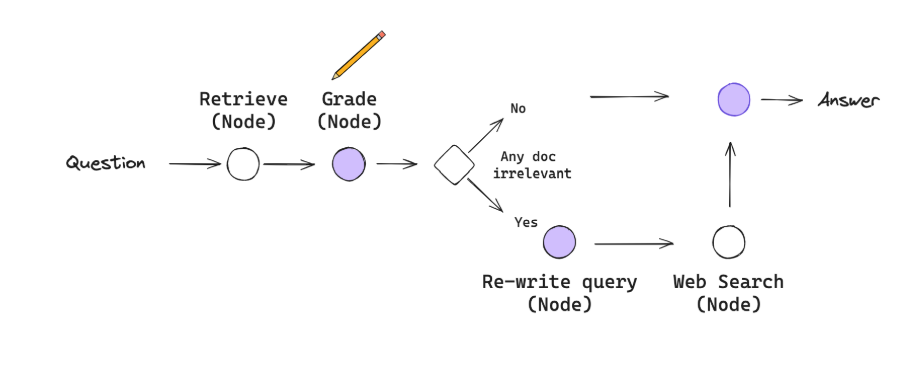

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs

USER_AGENT environment variable not set, consider setting it to identify your requests.


[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [4]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [5]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [6]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [7]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [9]:
### Generate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGroq(model_name="qwen/qwen3-32b", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

<think>
Okay, the user is asking about "agent memory" in the context of LLM-powered autonomous agents. Let me look through the provided documents to find relevant information.

First, the documents mention that memory in these agents is divided into short-term and long-term. Short-term memory is related to in-context learning, which I think refers to the model's ability to use information provided in the current prompt or conversation history. That makes sense because LLMs can process and retain information within a single interaction, but it's temporary.

Long-term memory is described as using external vector stores for retaining information over extended periods. This would allow the agent to remember data across different sessions or interactions, which is crucial for tasks requiring persistent memory. The documents also mention that long-term memory helps in fast retrieval, so the agent can access past information efficiently when needed.

Additionally, there's a part about memory 

In [10]:
### Question Re-writer

# LLM
llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)

# Prompt
system = """Your a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'<think>\nOkay, the user provided the initial question "agent memory" and wants me to formulate an improved version for better web search. Let me start by understanding what they\'re asking.\n\nFirst, "agent memory" is pretty vague. It could refer to different things like AI agents, software agents, or even human agents. Without context, it\'s hard to know exactly what they need. So, I need to consider possible interpretations.\n\nMaybe they\'re asking about how AI agents store and use memory, like in machine learning models. Or perhaps it\'s about memory management in software agents. Another angle could be the role of memory in agent-based systems or multi-agent systems.\n\nTo make the question more specific, I should add context. Words like "AI" or "artificial intelligence" could help narrow it down. Also, specifying the purpose, like "how do AI agents use memory to improve performance?" would make it clearer.\n\nAlternatively, if they\'re interested in the technical aspects, terms 

## Web Search Tool

In [11]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

C:\Users\Acer\AppData\Local\Temp\ipykernel_12648\730760015.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [12]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]
    

In [16]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    print(web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [19]:
# ...existing code...
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state.get("question")
    documents = state.get("documents", []) or []

    # Web search
    raw = web_search_tool.invoke({"query": question})
    print(f"web_search_tool returned type: {type(raw)}")

    # Normalize raw into a list of items
    if isinstance(raw, str):
        items = [raw]
    elif isinstance(raw, dict):
        # common shapes: {'results': [...]} or {'items': [...]} or single result dict
        if "results" in raw and isinstance(raw["results"], list):
            items = raw["results"]
        elif "items" in raw and isinstance(raw["items"], list):
            items = raw["items"]
        else:
            items = [raw]
    elif isinstance(raw, list):
        items = raw
    else:
        items = [str(raw)]

    # Extract text content from each item robustly
    contents = []
    for it in items:
        if isinstance(it, dict):
            if "content" in it:
                contents.append(it["content"])
            elif "text" in it:
                contents.append(it["text"])
            elif "snippet" in it:
                contents.append(it["snippet"])
            else:
                contents.append(str(it))
        elif hasattr(it, "page_content"):
            contents.append(it.page_content)
        else:
            contents.append(str(it))

    web_results_text = "\n".join(contents).strip()
    if web_results_text:
        documents.append(Document(page_content=web_results_text))
        print("---WEB RESULTS ADDED---")
    else:
        print("---NO WEB RESULTS---")

    return {"documents": documents, "question": question}
# ...existing code...

In [20]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

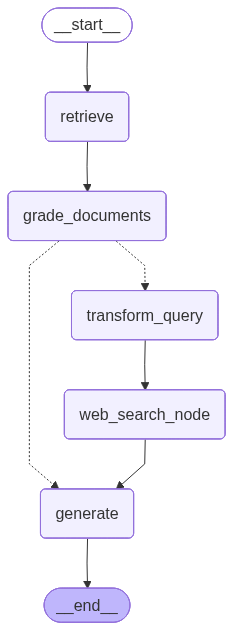

: 

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
web_search_tool returned type: <class 'str'>
---WEB RESULTS ADDED---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('<think>\n'
 'Okay, the user is asking about the types of agent memory. Let me check the '
 'provided context. The first document mentions short-term and long-term '
 'memory in LLM-powered agents. Short-term is related to in-context learning, '
 'like using prompt engineering, while long-term uses external storage for '
 'retaining information over time. The second document had an error, so I can '
 'ignor